# This notebook simulates a simple mountain destroyed by rainfall and glaciers


figured out that scipy zoom really makes the figures shine


## Principles:

* The land starts as rock

* Rain falls on a random set of figures at every step

* Rain flows downhill, and can barely scratch the rock, but drags the gravel along

* The temperature is determined by height

* Rain freezes to glacier if it's below zero

* Glaciers destroy the rock into gravel below them

* Glaciers flow downhill slowly

* When above zero, a glacier melts at a constant rate


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl

import scipy.signal as signal
import scipy.ndimage as ndimage
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

# Making a mountainside

In [12]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel

kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp

def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

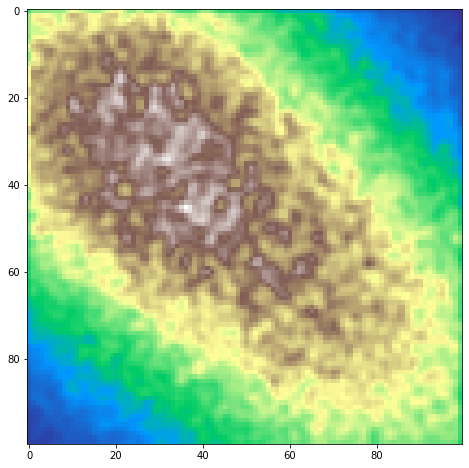

In [167]:
samples1 = np.random.multivariate_normal((1.7, 1.8), cov=np.eye(2), size=int(2.e6))
samples2 = np.random.multivariate_normal((0.4, 0.3), cov=np.eye(2), size=int(2.4e6))
# samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2)*1, size=1800000)
# samples3 = np.random.multivariate_normal((4.5, 1.8), cov=np.eye(2), size=1100000)
# samples4 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=2000000)
samples = np.concatenate((samples1, samples2))

bins = np.linspace(0, 2, 104)

bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins), density=True)[0] * 4
land = convolve_map(land, 1, which="gauss")
land = land[1:-2, 1:-1]

lmax = land.max()
land = (land / lmax)**3. * lmax
land *= 3000

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain)

In [168]:
zland = ndimage.zoom(land, 2)

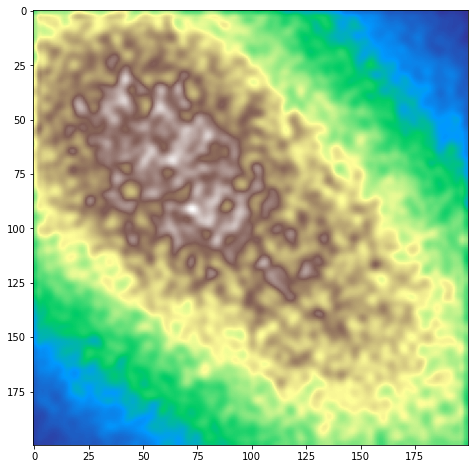

In [169]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(zland, cmap=plt.cm.terrain)

In [170]:
land.min()

125.07444361237111

# Erosion model of the mountain side

In [171]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

def null_edges(arr):
    arr[0, :] = 0.
    arr[:, 0] = 0.
    arr[:, -1] = 0.
    arr[-1, :] = 0.
    return arr

In [172]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [173]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def _calc_flows(self, vmap, outflow, cell):
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        return shifted_landslide.sum(axis=0)
    
    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        vmap += self._calc_flows(vmap, outflow, cell)
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, rainfall=1, fraction=0.2, seed=10):
        """
        This is adds new rain water to the water canvas
    
        """
        self.layers = np.sort(("water",))
        self.key = "water"
        self.rainfall = rainfall
        self.fraction = fraction
        self.rng = np.random.RandomState(seed)
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        rmax = 100
        rpiv = rmax * (1 - self.fraction)
        rainmap = np.random.random(size=water_local.shape) * rmax
        rainmap[rainmap <= rpiv] = 0.
        rainmap[rainmap > rpiv] = self.rainfall
        
        water_local += rainmap
        
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        


In [174]:
arr = np.linspace(0, 5000, 100)

In [175]:
def temperature(vals, h2k=3000, temperature_2k=0., temperature0=20):
    res = (temperature_2k - temperature0) / h2k * vals + temperature0
    return res

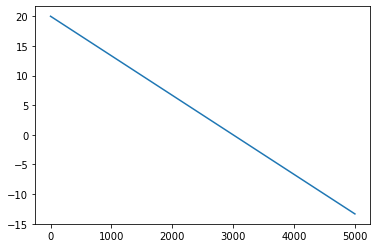

In [176]:
plt.plot(arr, temperature(arr))

In [285]:
   
class IceWaterGravelFlow(FlowRule):
    def __init__(self, altitude=10000, water_flow_rate=0.5, land_coerosion_rate=0.1,
                 drag_coeff=0.1, gravel_factor=4, flow_limit=10.,
                 ice_fracturing_rate=0.1, ice_melt_rate=0.05, ice_melt_min=40, ice_flow_rate=0.05,
                 ice_freeze_t=0, ice_melt_t=0,
                 temperature0=30, temperature_2k=0, h2k=3000.
                ):
        """
        This is a four component erosion model with glaciers
        
        This is a three component erosion model where water flows fast, and drags a fraction of the land with it
        Any land once dragged, will becone gravel, which erodes very easily
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        gravel_factor is the multiplier to the land coerosion rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("rock", "gravel" , "water", "ice", "temperature"))
        self.wkey = "water"
        self.lkey = "rock"
        self.gkey = "gravel"
        self.ikey = "ice"
        self.tkey = "temperature"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate
        self.drag_coeff = drag_coeff
        self.gravel_factor = gravel_factor
        self.ice_fracturing_rate = ice_fracturing_rate
        self.ice_melt_rate = ice_melt_rate
        self.ice_melt_min = ice_melt_min
        self.ice_flow_rate = ice_flow_rate
        self.altitude = altitude
        self.ice_freeze_t = ice_freeze_t
        self.ice_melt_t = ice_melt_t
        
        self.temperature0 = temperature0
        self.temperature_2k = temperature_2k
        self.h2k = h2k
        
    def get_temperature_map(self, height_local):
        res = (self.temperature_2k - self.temperature0) / self.h2k * height_local + self.temperature0
#         print(res)
        return res
    
    
    def freezing(self, ice, temp, water):
        """
        This is actually melting and freezing melting is negative freezing
        
        Ice has some time to melt, and to freeze,
        this is a self similar proportional process, with a minimum cutoff step
        """
        
        meltwater = np.zeros(ice.shape)
        newice = np.zeros(ice.shape)
        
        imelt = np.where(temp > self.ice_melt_t)
        ifreeze = np.where(temp < self.ice_freeze_t)
#         print(temp[imelt].mean())
#         print(temp[ifreeze].mean())
        
        meltwater[imelt] = ice[imelt] * self.ice_melt_rate
        ii = np.where(meltwater[imelt] < self.ice_melt_min)
        meltwater[imelt][ii] = ice[imelt][ii] # this cuts off the iteration process for melting graciers
        
        newice[ifreeze] = water[ifreeze] * self.ice_melt_rate
        ii = np.where(newice[ifreeze] < self.ice_melt_min)
        newice[ifreeze][ii] = water[ifreeze][ii] # this cuts off the iteration process for freezing glaciers        
        
        # This is just a two field component continuity equation
        ice += (newice - meltwater)
        water -= (newice - meltwater)
        
        return ice, water
        
                
    def evolve(self, cell):
        """
        It is interesting that the outflow direction is set by land + gravel,
        but the amount of drag possible is two
        """
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        rock_local = cell.canvases[self.lkey]
        rock_shifted = cell.shifted_canvases[self.lkey]
        
        gravel_local = cell.canvases[self.gkey]
        gravel_shifted = cell.shifted_canvases[self.gkey]
        
        water_local = cell.canvases[self.wkey]
        ice_local = cell.canvases[self.ikey]
        
        temp_height_local = rock_local + gravel_local
        temp_local = self.get_temperature_map(temp_height_local) # temperature is static, it matter locally only
        ice_local, water_local = self.freezing(ice_local, temp_local, water_local)
        
        water_shifted = cell.shifted_canvases[self.wkey]
        ice_shifted = cell.shifted_canvases[self.ikey]
        
        height_local = rock_local + gravel_local + water_local + ice_local
        height_shifted = rock_shifted + gravel_shifted + water_shifted + ice_shifted

        # 1) water flows along the gradient
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow_w = water_local * fractions * self.water_flow_rate
        water_local = self.calc_flows(water_local, outflow_w, cell)
        water_local = null_edges(water_local) # This models the part where water flows out of the canvas
        # no more land can outflow than there is difference
        # Due to the megaoutflow approximation, the water height can be VERY high, this means we need to rationalize
        # The amount of land drag possible to an actual sensible maximum
        
        # The rock must only eroded if there is no more gravel left... This is a really curious nonlinearity
        
        # and now we tag on glaciers to erode the bedrock into gravel, and flow
        outflow_i = ice_local * fractions * self.ice_flow_rate
        ice_local = self.calc_flows(ice_local, outflow_i, cell)
        ice_local = null_edges(ice_local)       # a glacier simply flows out of the frame and goes away to the distance 
        
        
        # 2) the gravel flows
        gflow_limit = np.sqrt(gravel_local) * self.drag_coeff * self.gravel_factor
        ii = np.where(gflow_limit > 0.1 * gravel_local)
        gflow_limit[ii] = 0.1 * gravel_local[ii]        
        gflow_limit = np.array([gflow_limit, ] * 4) / 4.
        outflow_g = (outflow_w + outflow_i) * self.land_coerosion_rate * self.gravel_factor
        ii = outflow_g > (gflow_limit)
        outflow_g[ii] = gflow_limit[ii]        
        gravel_local = self.calc_flows(gravel_local, outflow_g, cell)

        # 3) The rock erodes from water and ice flow
        # we have to establish the local gravel coverage
        # The rock is eroded into gravel by the flow of water and ice
        lflow_limit = np.sqrt(rock_local) * self.drag_coeff
        ii = np.where(lflow_limit > 0.1 * rock_local)
        lflow_limit[ii] = 0.1 * rock_local[ii]
        ii = np.where(gravel_local > 0)
        lflow_limit[ii] = 0. # This means the rock will never erode if its covered by gravel,
        # the gravel has to flow away first in order to occur
        lflow_limit = np.array([lflow_limit, ] * 4) / 4.
#         lflow_limit = np.array([rock_local * self.drag_coeff,] * 4) / 4 # limit how much land can be dragged at each point
        
        # in megaoutflow, water can pile up really high, this must be regularized
        outflow_l = outflow_w * self.land_coerosion_rate # this is water
        outflow_l += outflow_i * self.ice_fracturing_rate # This is ice
        ii = outflow_l > (lflow_limit)
        outflow_l[ii] = lflow_limit[ii]        
        
        rock_local -= outflow_l.sum(axis=0)    
        gravel_local += self._calc_flows(gravel_local, outflow_l, cell)
        

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: rock_local, self.gkey: gravel_local,
                        self.ikey: ice_local, self.tkey: temp_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    


In [306]:
rules = (
    RainFall(rainfall=0.02, fraction=0.25),
    IceWaterGravelFlow(land_coerosion_rate=0.05, water_flow_rate=0.9, drag_coeff=4, gravel_factor=10,
                       ice_fracturing_rate=0.2, ice_melt_rate=0.3, ice_melt_min=10, ice_flow_rate=0.1,
                       temperature0=24, temperature_2k=0, h2k=2500
                  ),
)
wmap = np.zeros(shape=zland.shape)
gmap = np.zeros(shape=zland.shape)
imap = np.zeros(shape=zland.shape)
tmap = np.zeros(shape=zland.shape) + 20.
initial_maps = {
    "rock": null_edges(zland * 0.8),
    "gravel": null_edges(zland * 0.2),
    "water": null_edges(wmap),
    "ice": null_edges(imap),
    "temperature": null_edges(tmap),
}

In [308]:
cs = CellSpace(initial_maps, rules)
cs.flow(10000, savestep=100)

all_rock = copy.deepcopy(cs.maps["rock"])
all_gravel = copy.deepcopy(cs.maps["gravel"])
all_waters = copy.deepcopy(cs.maps["water"])
all_ice = copy.deepcopy(cs.maps["ice"])
all_temperature = copy.deepcopy(cs.maps["temperature"])

0 out of 9999
1 out of 9999
2 out of 9999
3 out of 9999
4 out of 9999
5 out of 9999
6 out of 9999
7 out of 9999
8 out of 9999
9 out of 9999
10 out of 9999
11 out of 9999
12 out of 9999
13 out of 9999
14 out of 9999
15 out of 9999


/tmp/ipykernel_4431/31135115.py:113: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


16 out of 9999
17 out of 9999
18 out of 9999
19 out of 9999
20 out of 9999
21 out of 9999
22 out of 9999
23 out of 9999
24 out of 9999
25 out of 9999
26 out of 9999
27 out of 9999
28 out of 9999
29 out of 9999
30 out of 9999
31 out of 9999
32 out of 9999
33 out of 9999
34 out of 9999
35 out of 9999
36 out of 9999
37 out of 9999
38 out of 9999
39 out of 9999
40 out of 9999
41 out of 9999
42 out of 9999
43 out of 9999
44 out of 9999
45 out of 9999
46 out of 9999
47 out of 9999
48 out of 9999
49 out of 9999
50 out of 9999
51 out of 9999
52 out of 9999
53 out of 9999
54 out of 9999
55 out of 9999
56 out of 9999
57 out of 9999
58 out of 9999
59 out of 9999
60 out of 9999
61 out of 9999
62 out of 9999
63 out of 9999
64 out of 9999
65 out of 9999
66 out of 9999
67 out of 9999
68 out of 9999
69 out of 9999
70 out of 9999
71 out of 9999
72 out of 9999
73 out of 9999
74 out of 9999
75 out of 9999
76 out of 9999
77 out of 9999
78 out of 9999
79 out of 9999
80 out of 9999
81 out of 9999
82 out of 

543 out of 9999
544 out of 9999
545 out of 9999
546 out of 9999
547 out of 9999
548 out of 9999
549 out of 9999
550 out of 9999
551 out of 9999
552 out of 9999
553 out of 9999
554 out of 9999
555 out of 9999
556 out of 9999
557 out of 9999
558 out of 9999
559 out of 9999
560 out of 9999
561 out of 9999
562 out of 9999
563 out of 9999
564 out of 9999
565 out of 9999
566 out of 9999
567 out of 9999
568 out of 9999
569 out of 9999
570 out of 9999
571 out of 9999
572 out of 9999
573 out of 9999
574 out of 9999
575 out of 9999
576 out of 9999
577 out of 9999
578 out of 9999
579 out of 9999
580 out of 9999
581 out of 9999
582 out of 9999
583 out of 9999
584 out of 9999
585 out of 9999
586 out of 9999
587 out of 9999
588 out of 9999
589 out of 9999
590 out of 9999
591 out of 9999
592 out of 9999
593 out of 9999
594 out of 9999
595 out of 9999
596 out of 9999
597 out of 9999
598 out of 9999
599 out of 9999
600 out of 9999
601 out of 9999
602 out of 9999
603 out of 9999
604 out of 9999
605 out 

1063 out of 9999
1064 out of 9999
1065 out of 9999
1066 out of 9999
1067 out of 9999
1068 out of 9999
1069 out of 9999
1070 out of 9999
1071 out of 9999
1072 out of 9999
1073 out of 9999
1074 out of 9999
1075 out of 9999
1076 out of 9999
1077 out of 9999
1078 out of 9999
1079 out of 9999
1080 out of 9999
1081 out of 9999
1082 out of 9999
1083 out of 9999
1084 out of 9999
1085 out of 9999
1086 out of 9999
1087 out of 9999
1088 out of 9999
1089 out of 9999
1090 out of 9999
1091 out of 9999
1092 out of 9999
1093 out of 9999
1094 out of 9999
1095 out of 9999
1096 out of 9999
1097 out of 9999
1098 out of 9999
1099 out of 9999
1100 out of 9999
1101 out of 9999
1102 out of 9999
1103 out of 9999
1104 out of 9999
1105 out of 9999
1106 out of 9999
1107 out of 9999
1108 out of 9999
1109 out of 9999
1110 out of 9999
1111 out of 9999
1112 out of 9999
1113 out of 9999
1114 out of 9999
1115 out of 9999
1116 out of 9999
1117 out of 9999
1118 out of 9999
1119 out of 9999
1120 out of 9999
1121 out of 99

1549 out of 9999
1550 out of 9999
1551 out of 9999
1552 out of 9999
1553 out of 9999
1554 out of 9999
1555 out of 9999
1556 out of 9999
1557 out of 9999
1558 out of 9999
1559 out of 9999
1560 out of 9999
1561 out of 9999
1562 out of 9999
1563 out of 9999
1564 out of 9999
1565 out of 9999
1566 out of 9999
1567 out of 9999
1568 out of 9999
1569 out of 9999
1570 out of 9999
1571 out of 9999
1572 out of 9999
1573 out of 9999
1574 out of 9999
1575 out of 9999
1576 out of 9999
1577 out of 9999
1578 out of 9999
1579 out of 9999
1580 out of 9999
1581 out of 9999
1582 out of 9999
1583 out of 9999
1584 out of 9999
1585 out of 9999
1586 out of 9999
1587 out of 9999
1588 out of 9999
1589 out of 9999
1590 out of 9999
1591 out of 9999
1592 out of 9999
1593 out of 9999
1594 out of 9999
1595 out of 9999
1596 out of 9999
1597 out of 9999
1598 out of 9999
1599 out of 9999
1600 out of 9999
1601 out of 9999
1602 out of 9999
1603 out of 9999
1604 out of 9999
1605 out of 9999
1606 out of 9999
1607 out of 99

2032 out of 9999
2033 out of 9999
2034 out of 9999
2035 out of 9999
2036 out of 9999
2037 out of 9999
2038 out of 9999
2039 out of 9999
2040 out of 9999
2041 out of 9999
2042 out of 9999
2043 out of 9999
2044 out of 9999
2045 out of 9999
2046 out of 9999
2047 out of 9999
2048 out of 9999
2049 out of 9999
2050 out of 9999
2051 out of 9999
2052 out of 9999
2053 out of 9999
2054 out of 9999
2055 out of 9999
2056 out of 9999
2057 out of 9999
2058 out of 9999
2059 out of 9999
2060 out of 9999
2061 out of 9999
2062 out of 9999
2063 out of 9999
2064 out of 9999
2065 out of 9999
2066 out of 9999
2067 out of 9999
2068 out of 9999
2069 out of 9999
2070 out of 9999
2071 out of 9999
2072 out of 9999
2073 out of 9999
2074 out of 9999
2075 out of 9999
2076 out of 9999
2077 out of 9999
2078 out of 9999
2079 out of 9999
2080 out of 9999
2081 out of 9999
2082 out of 9999
2083 out of 9999
2084 out of 9999
2085 out of 9999
2086 out of 9999
2087 out of 9999
2088 out of 9999
2089 out of 9999
2090 out of 99

2522 out of 9999
2523 out of 9999
2524 out of 9999
2525 out of 9999
2526 out of 9999
2527 out of 9999
2528 out of 9999
2529 out of 9999
2530 out of 9999
2531 out of 9999
2532 out of 9999
2533 out of 9999
2534 out of 9999
2535 out of 9999
2536 out of 9999
2537 out of 9999
2538 out of 9999
2539 out of 9999
2540 out of 9999
2541 out of 9999
2542 out of 9999
2543 out of 9999
2544 out of 9999
2545 out of 9999
2546 out of 9999
2547 out of 9999
2548 out of 9999
2549 out of 9999
2550 out of 9999
2551 out of 9999
2552 out of 9999
2553 out of 9999
2554 out of 9999
2555 out of 9999
2556 out of 9999
2557 out of 9999
2558 out of 9999
2559 out of 9999
2560 out of 9999
2561 out of 9999
2562 out of 9999
2563 out of 9999
2564 out of 9999
2565 out of 9999
2566 out of 9999
2567 out of 9999
2568 out of 9999
2569 out of 9999
2570 out of 9999
2571 out of 9999
2572 out of 9999
2573 out of 9999
2574 out of 9999
2575 out of 9999
2576 out of 9999
2577 out of 9999
2578 out of 9999
2579 out of 9999
2580 out of 99

3015 out of 9999
3016 out of 9999
3017 out of 9999
3018 out of 9999
3019 out of 9999
3020 out of 9999
3021 out of 9999
3022 out of 9999
3023 out of 9999
3024 out of 9999
3025 out of 9999
3026 out of 9999
3027 out of 9999
3028 out of 9999
3029 out of 9999
3030 out of 9999
3031 out of 9999
3032 out of 9999
3033 out of 9999
3034 out of 9999
3035 out of 9999
3036 out of 9999
3037 out of 9999
3038 out of 9999
3039 out of 9999
3040 out of 9999
3041 out of 9999
3042 out of 9999
3043 out of 9999
3044 out of 9999
3045 out of 9999
3046 out of 9999
3047 out of 9999
3048 out of 9999
3049 out of 9999
3050 out of 9999
3051 out of 9999
3052 out of 9999
3053 out of 9999
3054 out of 9999
3055 out of 9999
3056 out of 9999
3057 out of 9999
3058 out of 9999
3059 out of 9999
3060 out of 9999
3061 out of 9999
3062 out of 9999
3063 out of 9999
3064 out of 9999
3065 out of 9999
3066 out of 9999
3067 out of 9999
3068 out of 9999
3069 out of 9999
3070 out of 9999
3071 out of 9999
3072 out of 9999
3073 out of 99

3506 out of 9999
3507 out of 9999
3508 out of 9999
3509 out of 9999
3510 out of 9999
3511 out of 9999
3512 out of 9999
3513 out of 9999
3514 out of 9999
3515 out of 9999
3516 out of 9999
3517 out of 9999
3518 out of 9999
3519 out of 9999
3520 out of 9999
3521 out of 9999
3522 out of 9999
3523 out of 9999
3524 out of 9999
3525 out of 9999
3526 out of 9999
3527 out of 9999
3528 out of 9999
3529 out of 9999
3530 out of 9999
3531 out of 9999
3532 out of 9999
3533 out of 9999
3534 out of 9999
3535 out of 9999
3536 out of 9999
3537 out of 9999
3538 out of 9999
3539 out of 9999
3540 out of 9999
3541 out of 9999
3542 out of 9999
3543 out of 9999
3544 out of 9999
3545 out of 9999
3546 out of 9999
3547 out of 9999
3548 out of 9999
3549 out of 9999
3550 out of 9999
3551 out of 9999
3552 out of 9999
3553 out of 9999
3554 out of 9999
3555 out of 9999
3556 out of 9999
3557 out of 9999
3558 out of 9999
3559 out of 9999
3560 out of 9999
3561 out of 9999
3562 out of 9999
3563 out of 9999
3564 out of 99

3998 out of 9999
3999 out of 9999
4000 out of 9999
4001 out of 9999
4002 out of 9999
4003 out of 9999
4004 out of 9999
4005 out of 9999
4006 out of 9999
4007 out of 9999
4008 out of 9999
4009 out of 9999
4010 out of 9999
4011 out of 9999
4012 out of 9999
4013 out of 9999
4014 out of 9999
4015 out of 9999
4016 out of 9999
4017 out of 9999
4018 out of 9999
4019 out of 9999
4020 out of 9999
4021 out of 9999
4022 out of 9999
4023 out of 9999
4024 out of 9999
4025 out of 9999
4026 out of 9999
4027 out of 9999
4028 out of 9999
4029 out of 9999
4030 out of 9999
4031 out of 9999
4032 out of 9999
4033 out of 9999
4034 out of 9999
4035 out of 9999
4036 out of 9999
4037 out of 9999
4038 out of 9999
4039 out of 9999
4040 out of 9999
4041 out of 9999
4042 out of 9999
4043 out of 9999
4044 out of 9999
4045 out of 9999
4046 out of 9999
4047 out of 9999
4048 out of 9999
4049 out of 9999
4050 out of 9999
4051 out of 9999
4052 out of 9999
4053 out of 9999
4054 out of 9999
4055 out of 9999
4056 out of 99

4483 out of 9999
4484 out of 9999
4485 out of 9999
4486 out of 9999
4487 out of 9999
4488 out of 9999
4489 out of 9999
4490 out of 9999
4491 out of 9999
4492 out of 9999
4493 out of 9999
4494 out of 9999
4495 out of 9999
4496 out of 9999
4497 out of 9999
4498 out of 9999
4499 out of 9999
4500 out of 9999
4501 out of 9999
4502 out of 9999
4503 out of 9999
4504 out of 9999
4505 out of 9999
4506 out of 9999
4507 out of 9999
4508 out of 9999
4509 out of 9999
4510 out of 9999
4511 out of 9999
4512 out of 9999
4513 out of 9999
4514 out of 9999
4515 out of 9999
4516 out of 9999
4517 out of 9999
4518 out of 9999
4519 out of 9999
4520 out of 9999
4521 out of 9999
4522 out of 9999
4523 out of 9999
4524 out of 9999
4525 out of 9999
4526 out of 9999
4527 out of 9999
4528 out of 9999
4529 out of 9999
4530 out of 9999
4531 out of 9999
4532 out of 9999
4533 out of 9999
4534 out of 9999
4535 out of 9999
4536 out of 9999
4537 out of 9999
4538 out of 9999
4539 out of 9999
4540 out of 9999
4541 out of 99

4975 out of 9999
4976 out of 9999
4977 out of 9999
4978 out of 9999
4979 out of 9999
4980 out of 9999
4981 out of 9999
4982 out of 9999
4983 out of 9999
4984 out of 9999
4985 out of 9999
4986 out of 9999
4987 out of 9999
4988 out of 9999
4989 out of 9999
4990 out of 9999
4991 out of 9999
4992 out of 9999
4993 out of 9999
4994 out of 9999
4995 out of 9999
4996 out of 9999
4997 out of 9999
4998 out of 9999
4999 out of 9999
5000 out of 9999
5001 out of 9999
5002 out of 9999
5003 out of 9999
5004 out of 9999
5005 out of 9999
5006 out of 9999
5007 out of 9999
5008 out of 9999
5009 out of 9999
5010 out of 9999
5011 out of 9999
5012 out of 9999
5013 out of 9999
5014 out of 9999
5015 out of 9999
5016 out of 9999
5017 out of 9999
5018 out of 9999
5019 out of 9999
5020 out of 9999
5021 out of 9999
5022 out of 9999
5023 out of 9999
5024 out of 9999
5025 out of 9999
5026 out of 9999
5027 out of 9999
5028 out of 9999
5029 out of 9999
5030 out of 9999
5031 out of 9999
5032 out of 9999
5033 out of 99

5470 out of 9999
5471 out of 9999
5472 out of 9999
5473 out of 9999
5474 out of 9999
5475 out of 9999
5476 out of 9999
5477 out of 9999
5478 out of 9999
5479 out of 9999
5480 out of 9999
5481 out of 9999
5482 out of 9999
5483 out of 9999
5484 out of 9999
5485 out of 9999
5486 out of 9999
5487 out of 9999
5488 out of 9999
5489 out of 9999
5490 out of 9999
5491 out of 9999
5492 out of 9999
5493 out of 9999
5494 out of 9999
5495 out of 9999
5496 out of 9999
5497 out of 9999
5498 out of 9999
5499 out of 9999
5500 out of 9999
5501 out of 9999
5502 out of 9999
5503 out of 9999
5504 out of 9999
5505 out of 9999
5506 out of 9999
5507 out of 9999
5508 out of 9999
5509 out of 9999
5510 out of 9999
5511 out of 9999
5512 out of 9999
5513 out of 9999
5514 out of 9999
5515 out of 9999
5516 out of 9999
5517 out of 9999
5518 out of 9999
5519 out of 9999
5520 out of 9999
5521 out of 9999
5522 out of 9999
5523 out of 9999
5524 out of 9999
5525 out of 9999
5526 out of 9999
5527 out of 9999
5528 out of 99

5962 out of 9999
5963 out of 9999
5964 out of 9999
5965 out of 9999
5966 out of 9999
5967 out of 9999
5968 out of 9999
5969 out of 9999
5970 out of 9999
5971 out of 9999
5972 out of 9999
5973 out of 9999
5974 out of 9999
5975 out of 9999
5976 out of 9999
5977 out of 9999
5978 out of 9999
5979 out of 9999
5980 out of 9999
5981 out of 9999
5982 out of 9999
5983 out of 9999
5984 out of 9999
5985 out of 9999
5986 out of 9999
5987 out of 9999
5988 out of 9999
5989 out of 9999
5990 out of 9999
5991 out of 9999
5992 out of 9999
5993 out of 9999
5994 out of 9999
5995 out of 9999
5996 out of 9999
5997 out of 9999
5998 out of 9999
5999 out of 9999
6000 out of 9999
6001 out of 9999
6002 out of 9999
6003 out of 9999
6004 out of 9999
6005 out of 9999
6006 out of 9999
6007 out of 9999
6008 out of 9999
6009 out of 9999
6010 out of 9999
6011 out of 9999
6012 out of 9999
6013 out of 9999
6014 out of 9999
6015 out of 9999
6016 out of 9999
6017 out of 9999
6018 out of 9999
6019 out of 9999
6020 out of 99

6445 out of 9999
6446 out of 9999
6447 out of 9999
6448 out of 9999
6449 out of 9999
6450 out of 9999
6451 out of 9999
6452 out of 9999
6453 out of 9999
6454 out of 9999
6455 out of 9999
6456 out of 9999
6457 out of 9999
6458 out of 9999
6459 out of 9999
6460 out of 9999
6461 out of 9999
6462 out of 9999
6463 out of 9999
6464 out of 9999
6465 out of 9999
6466 out of 9999
6467 out of 9999
6468 out of 9999
6469 out of 9999
6470 out of 9999
6471 out of 9999
6472 out of 9999
6473 out of 9999
6474 out of 9999
6475 out of 9999
6476 out of 9999
6477 out of 9999
6478 out of 9999
6479 out of 9999
6480 out of 9999
6481 out of 9999
6482 out of 9999
6483 out of 9999
6484 out of 9999
6485 out of 9999
6486 out of 9999
6487 out of 9999
6488 out of 9999
6489 out of 9999
6490 out of 9999
6491 out of 9999
6492 out of 9999
6493 out of 9999
6494 out of 9999
6495 out of 9999
6496 out of 9999
6497 out of 9999
6498 out of 9999
6499 out of 9999
6500 out of 9999
6501 out of 9999
6502 out of 9999
6503 out of 99

6936 out of 9999
6937 out of 9999
6938 out of 9999
6939 out of 9999
6940 out of 9999
6941 out of 9999
6942 out of 9999
6943 out of 9999
6944 out of 9999
6945 out of 9999
6946 out of 9999
6947 out of 9999
6948 out of 9999
6949 out of 9999
6950 out of 9999
6951 out of 9999
6952 out of 9999
6953 out of 9999
6954 out of 9999
6955 out of 9999
6956 out of 9999
6957 out of 9999
6958 out of 9999
6959 out of 9999
6960 out of 9999
6961 out of 9999
6962 out of 9999
6963 out of 9999
6964 out of 9999
6965 out of 9999
6966 out of 9999
6967 out of 9999
6968 out of 9999
6969 out of 9999
6970 out of 9999
6971 out of 9999
6972 out of 9999
6973 out of 9999
6974 out of 9999
6975 out of 9999
6976 out of 9999
6977 out of 9999
6978 out of 9999
6979 out of 9999
6980 out of 9999
6981 out of 9999
6982 out of 9999
6983 out of 9999
6984 out of 9999
6985 out of 9999
6986 out of 9999
6987 out of 9999
6988 out of 9999
6989 out of 9999
6990 out of 9999
6991 out of 9999
6992 out of 9999
6993 out of 9999
6994 out of 99

7425 out of 9999
7426 out of 9999
7427 out of 9999
7428 out of 9999
7429 out of 9999
7430 out of 9999
7431 out of 9999
7432 out of 9999
7433 out of 9999
7434 out of 9999
7435 out of 9999
7436 out of 9999
7437 out of 9999
7438 out of 9999
7439 out of 9999
7440 out of 9999
7441 out of 9999
7442 out of 9999
7443 out of 9999
7444 out of 9999
7445 out of 9999
7446 out of 9999
7447 out of 9999
7448 out of 9999
7449 out of 9999
7450 out of 9999
7451 out of 9999
7452 out of 9999
7453 out of 9999
7454 out of 9999
7455 out of 9999
7456 out of 9999
7457 out of 9999
7458 out of 9999
7459 out of 9999
7460 out of 9999
7461 out of 9999
7462 out of 9999
7463 out of 9999
7464 out of 9999
7465 out of 9999
7466 out of 9999
7467 out of 9999
7468 out of 9999
7469 out of 9999
7470 out of 9999
7471 out of 9999
7472 out of 9999
7473 out of 9999
7474 out of 9999
7475 out of 9999
7476 out of 9999
7477 out of 9999
7478 out of 9999
7479 out of 9999
7480 out of 9999
7481 out of 9999
7482 out of 9999
7483 out of 99

7915 out of 9999
7916 out of 9999
7917 out of 9999
7918 out of 9999
7919 out of 9999
7920 out of 9999
7921 out of 9999
7922 out of 9999
7923 out of 9999
7924 out of 9999
7925 out of 9999
7926 out of 9999
7927 out of 9999
7928 out of 9999
7929 out of 9999
7930 out of 9999
7931 out of 9999
7932 out of 9999
7933 out of 9999
7934 out of 9999
7935 out of 9999
7936 out of 9999
7937 out of 9999
7938 out of 9999
7939 out of 9999
7940 out of 9999
7941 out of 9999
7942 out of 9999
7943 out of 9999
7944 out of 9999
7945 out of 9999
7946 out of 9999
7947 out of 9999
7948 out of 9999
7949 out of 9999
7950 out of 9999
7951 out of 9999
7952 out of 9999
7953 out of 9999
7954 out of 9999
7955 out of 9999
7956 out of 9999
7957 out of 9999
7958 out of 9999
7959 out of 9999
7960 out of 9999
7961 out of 9999
7962 out of 9999
7963 out of 9999
7964 out of 9999
7965 out of 9999
7966 out of 9999
7967 out of 9999
7968 out of 9999
7969 out of 9999
7970 out of 9999
7971 out of 9999
7972 out of 9999
7973 out of 99

8401 out of 9999
8402 out of 9999
8403 out of 9999
8404 out of 9999
8405 out of 9999
8406 out of 9999
8407 out of 9999
8408 out of 9999
8409 out of 9999
8410 out of 9999
8411 out of 9999
8412 out of 9999
8413 out of 9999
8414 out of 9999
8415 out of 9999
8416 out of 9999
8417 out of 9999
8418 out of 9999
8419 out of 9999
8420 out of 9999
8421 out of 9999
8422 out of 9999
8423 out of 9999
8424 out of 9999
8425 out of 9999
8426 out of 9999
8427 out of 9999
8428 out of 9999
8429 out of 9999
8430 out of 9999
8431 out of 9999
8432 out of 9999
8433 out of 9999
8434 out of 9999
8435 out of 9999
8436 out of 9999
8437 out of 9999
8438 out of 9999
8439 out of 9999
8440 out of 9999
8441 out of 9999
8442 out of 9999
8443 out of 9999
8444 out of 9999
8445 out of 9999
8446 out of 9999
8447 out of 9999
8448 out of 9999
8449 out of 9999
8450 out of 9999
8451 out of 9999
8452 out of 9999
8453 out of 9999
8454 out of 9999
8455 out of 9999
8456 out of 9999
8457 out of 9999
8458 out of 9999
8459 out of 99

8892 out of 9999
8893 out of 9999
8894 out of 9999
8895 out of 9999
8896 out of 9999
8897 out of 9999
8898 out of 9999
8899 out of 9999
8900 out of 9999
8901 out of 9999
8902 out of 9999
8903 out of 9999
8904 out of 9999
8905 out of 9999
8906 out of 9999
8907 out of 9999
8908 out of 9999
8909 out of 9999
8910 out of 9999
8911 out of 9999
8912 out of 9999
8913 out of 9999
8914 out of 9999
8915 out of 9999
8916 out of 9999
8917 out of 9999
8918 out of 9999
8919 out of 9999
8920 out of 9999
8921 out of 9999
8922 out of 9999
8923 out of 9999
8924 out of 9999
8925 out of 9999
8926 out of 9999
8927 out of 9999
8928 out of 9999
8929 out of 9999
8930 out of 9999
8931 out of 9999
8932 out of 9999
8933 out of 9999
8934 out of 9999
8935 out of 9999
8936 out of 9999
8937 out of 9999
8938 out of 9999
8939 out of 9999
8940 out of 9999
8941 out of 9999
8942 out of 9999
8943 out of 9999
8944 out of 9999
8945 out of 9999
8946 out of 9999
8947 out of 9999
8948 out of 9999
8949 out of 9999
8950 out of 99

9386 out of 9999
9387 out of 9999
9388 out of 9999
9389 out of 9999
9390 out of 9999
9391 out of 9999
9392 out of 9999
9393 out of 9999
9394 out of 9999
9395 out of 9999
9396 out of 9999
9397 out of 9999
9398 out of 9999
9399 out of 9999
9400 out of 9999
9401 out of 9999
9402 out of 9999
9403 out of 9999
9404 out of 9999
9405 out of 9999
9406 out of 9999
9407 out of 9999
9408 out of 9999
9409 out of 9999
9410 out of 9999
9411 out of 9999
9412 out of 9999
9413 out of 9999
9414 out of 9999
9415 out of 9999
9416 out of 9999
9417 out of 9999
9418 out of 9999
9419 out of 9999
9420 out of 9999
9421 out of 9999
9422 out of 9999
9423 out of 9999
9424 out of 9999
9425 out of 9999
9426 out of 9999
9427 out of 9999
9428 out of 9999
9429 out of 9999
9430 out of 9999
9431 out of 9999
9432 out of 9999
9433 out of 9999
9434 out of 9999
9435 out of 9999
9436 out of 9999
9437 out of 9999
9438 out of 9999
9439 out of 9999
9440 out of 9999
9441 out of 9999
9442 out of 9999
9443 out of 9999
9444 out of 99

9881 out of 9999
9882 out of 9999
9883 out of 9999
9884 out of 9999
9885 out of 9999
9886 out of 9999
9887 out of 9999
9888 out of 9999
9889 out of 9999
9890 out of 9999
9891 out of 9999
9892 out of 9999
9893 out of 9999
9894 out of 9999
9895 out of 9999
9896 out of 9999
9897 out of 9999
9898 out of 9999
9899 out of 9999
9900 out of 9999
9901 out of 9999
9902 out of 9999
9903 out of 9999
9904 out of 9999
9905 out of 9999
9906 out of 9999
9907 out of 9999
9908 out of 9999
9909 out of 9999
9910 out of 9999
9911 out of 9999
9912 out of 9999
9913 out of 9999
9914 out of 9999
9915 out of 9999
9916 out of 9999
9917 out of 9999
9918 out of 9999
9919 out of 9999
9920 out of 9999
9921 out of 9999
9922 out of 9999
9923 out of 9999
9924 out of 9999
9925 out of 9999
9926 out of 9999
9927 out of 9999
9928 out of 9999
9929 out of 9999
9930 out of 9999
9931 out of 9999
9932 out of 9999
9933 out of 9999
9934 out of 9999
9935 out of 9999
9936 out of 9999
9937 out of 9999
9938 out of 9999
9939 out of 99

In [309]:
len(all_rock)

101

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
# plt.axis("off")

ims = []
for i in np.arange(101):
    tmp = all_rock[i] + all_gravel[i]
    im1 = ax.imshow(tmp, cmap=plt.cm.terrain, animated=True)    
    
    alphas = all_ice[i] / 10
    alphas[alphas > 1] = 1
    im2 = ax.imshow(all_ice[i], cmap=plt.cm.cool, vmin=0, vmax=40, alpha=alphas, animated=True)
    
    alphas = all_waters[i] / 10
    alphas[alphas > 1] = 1
    im3 = ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=40, alpha=alphas, animated=True)
    
    ims.append((im1, im2, im3))

ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=200, blit=True)

HTML(ani.to_jshtml())

In [304]:
for i in np.arange(50):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)    tmp = all_rock[i] + all_gravel[i]
    ax.imshow(tmp, cmap=plt.cm.terrain)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)


#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

    alphas = all_ice[i] / 10
    alphas[alphas > 1] = 1
    ax.imshow(all_ice[i], cmap=plt.cm.cool, vmin=0, vmax=40, alpha=alphas)

    alphas = all_waters[i] / 10
    alphas[alphas > 1] = 1
    ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=40, alpha=alphas)
#     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=1)

SyntaxError: invalid syntax (3318532082.py, line 5)

In [281]:
# for i in np.arange(20):
#     fig = plt.figure(figsize=(12, 12))
#     ax = fig.add_subplot(111)
#     title = "Run  save step " + str(i)
#     ax.set_title(title)
    
# #     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
#     tmp = all_temperature[i]
#     ax.imshow(tmp, cmap=plt.cm.bwr, vmax=30, vmin=-20)
    

# #         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
# #     tmp = ndimage.zoom(, 4)

# #     alphas = all_ice[i] / 10
# #     alphas[alphas > 1] = 1
# #     ax.imshow(all_ice[i], cmap=plt.cm.gray_r, vmin=0, vmax=10, alpha=alphas)

# #     alphas = all_waters[i] / 10
# #     alphas[alphas > 1] = 1
# #     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)
# #     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=1)

/tmp/ipykernel_4431/1678876373.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


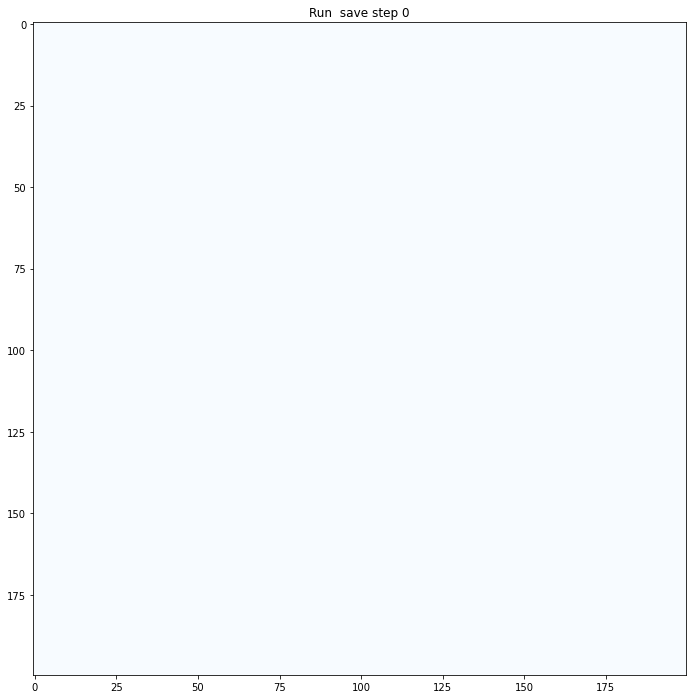

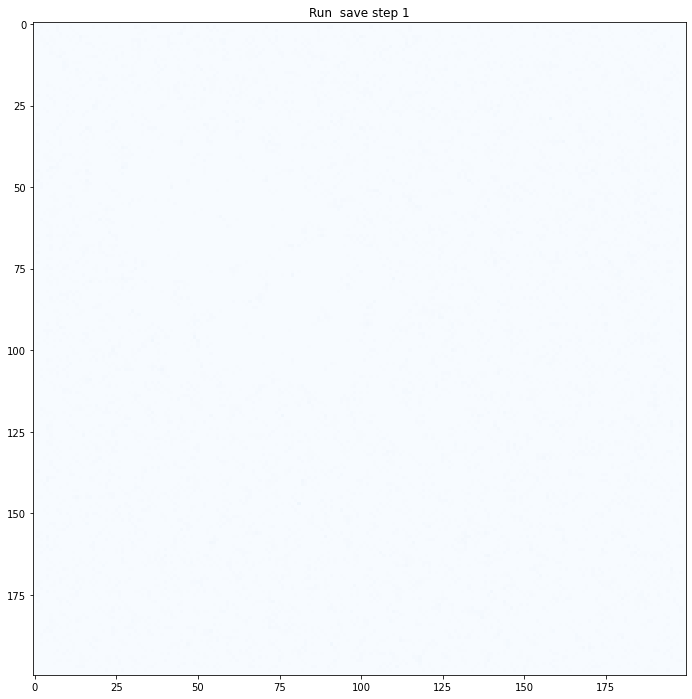

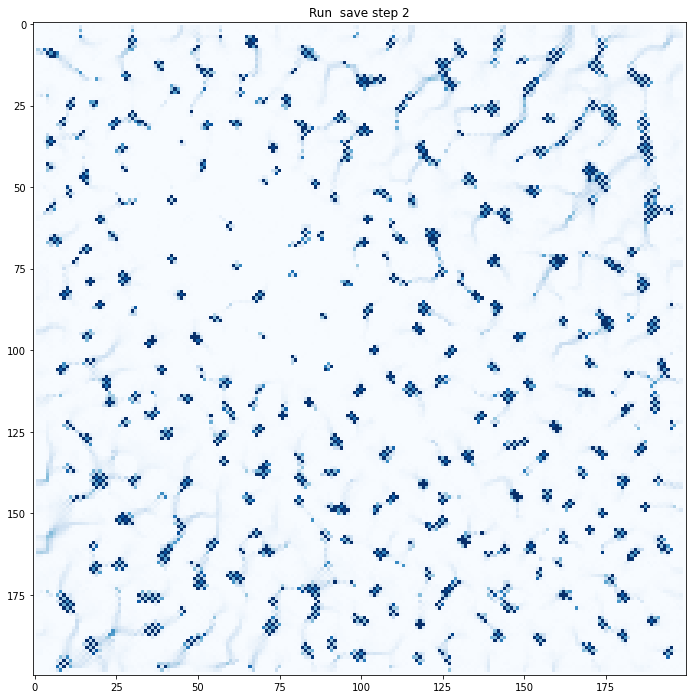

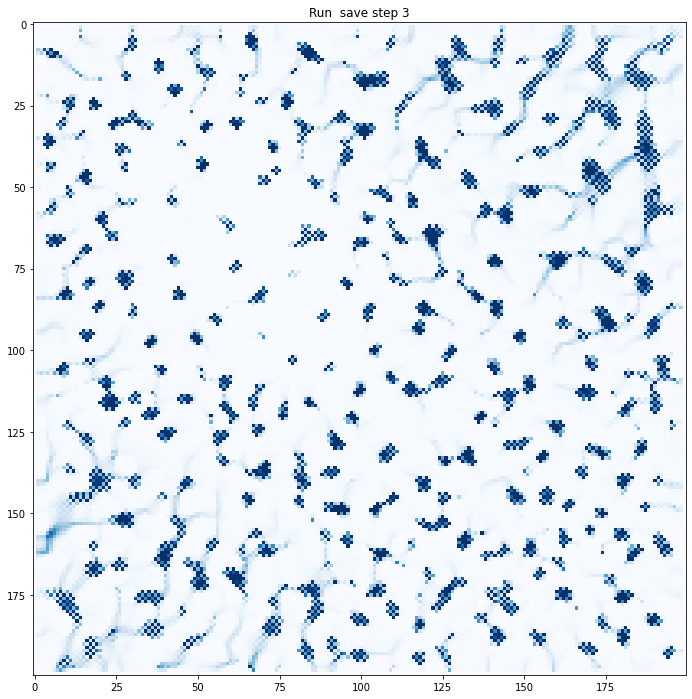

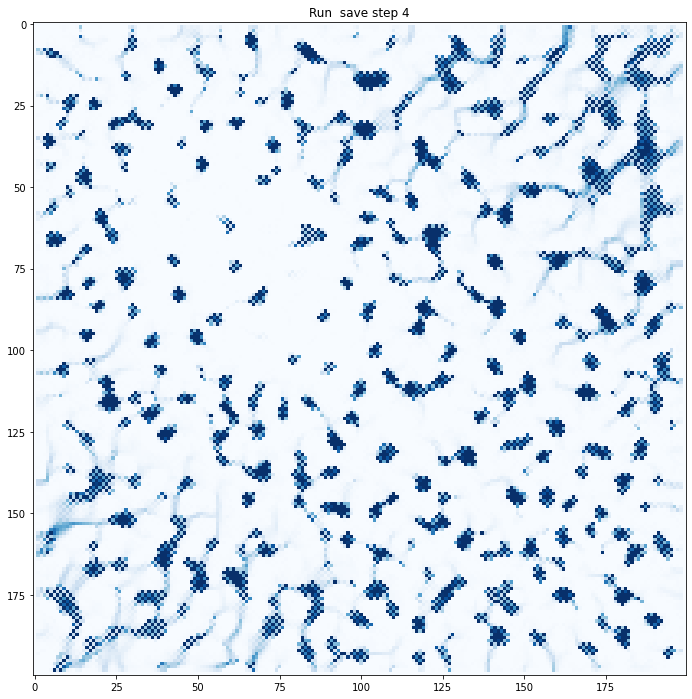

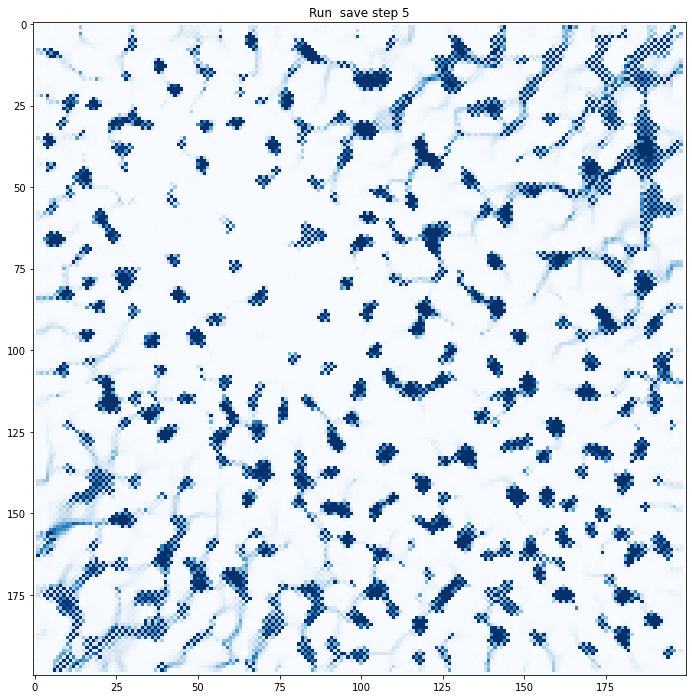

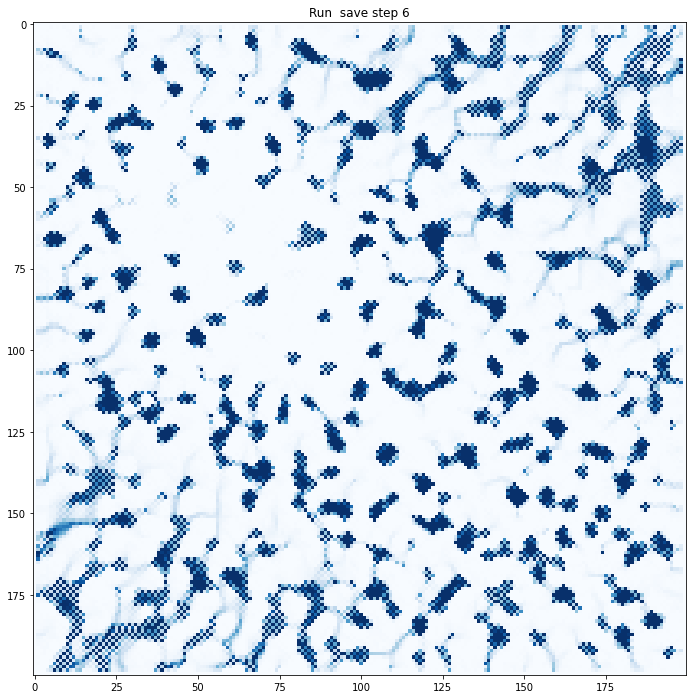

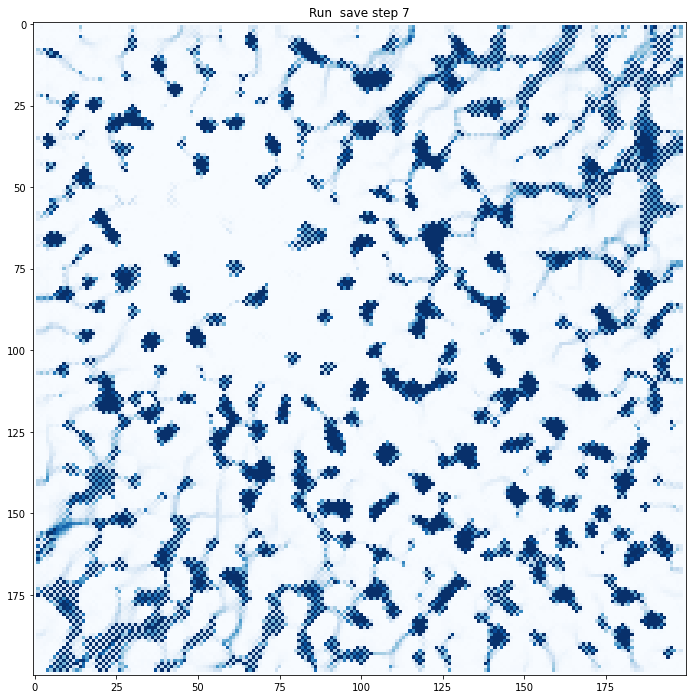

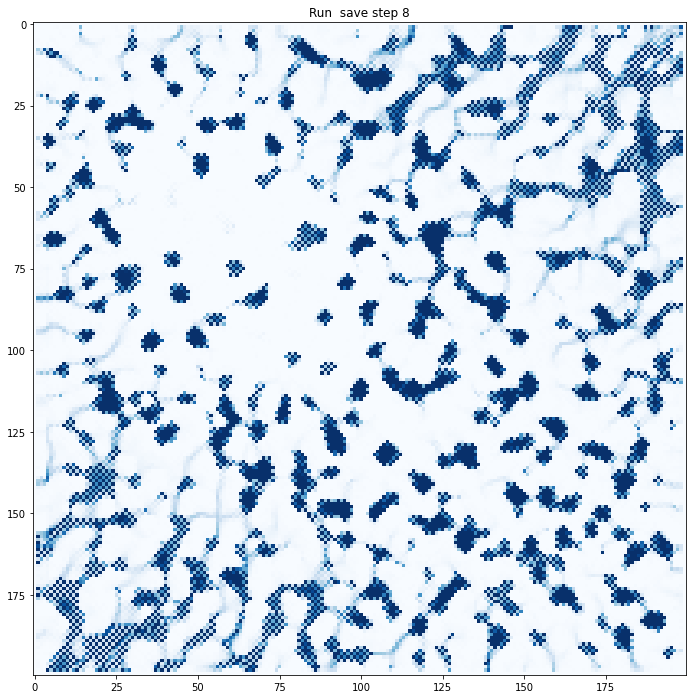

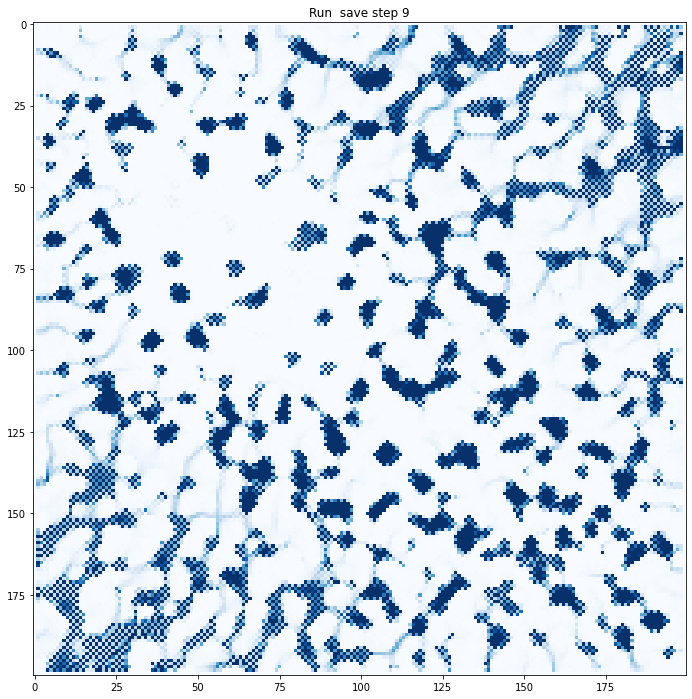

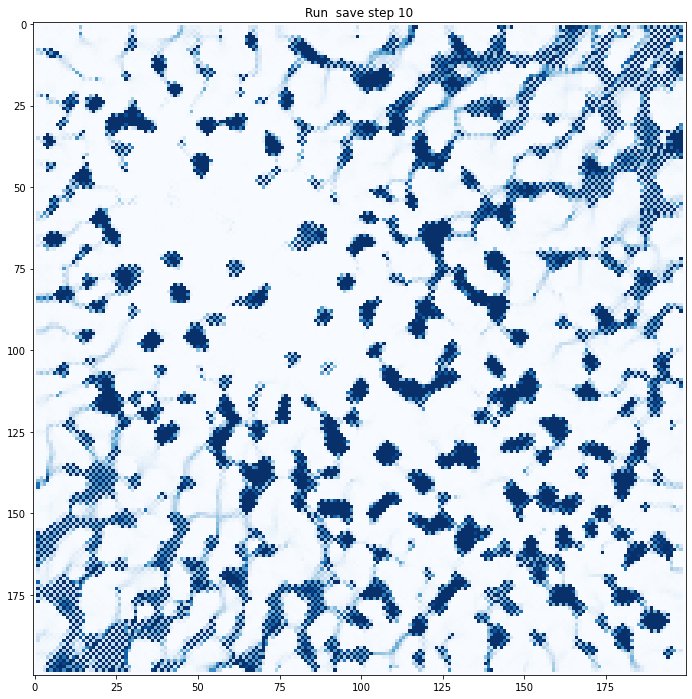

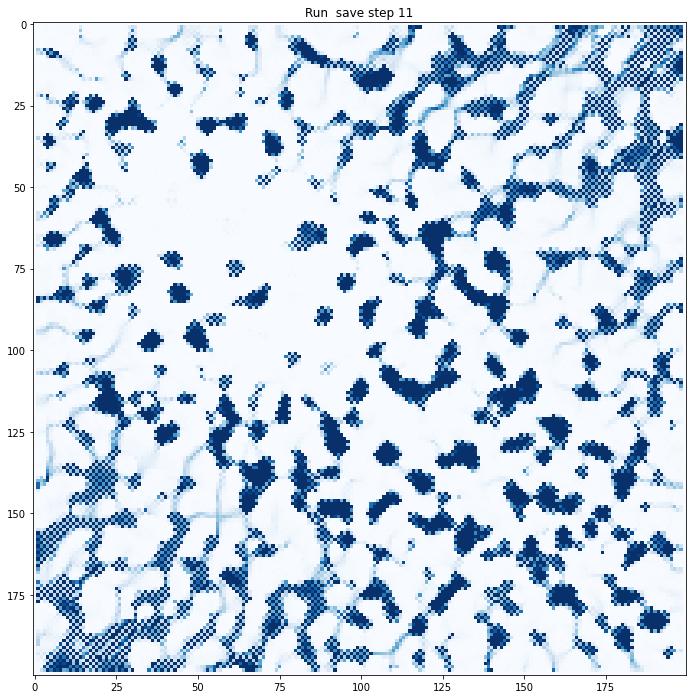

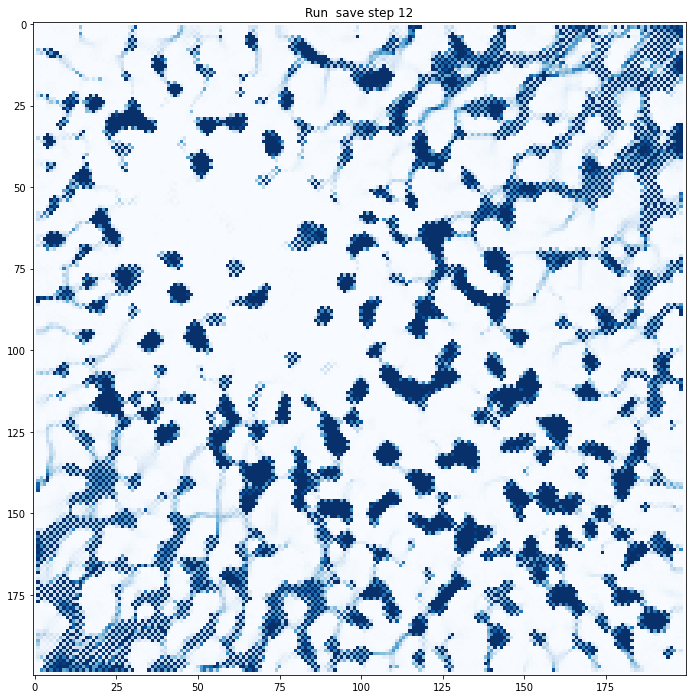

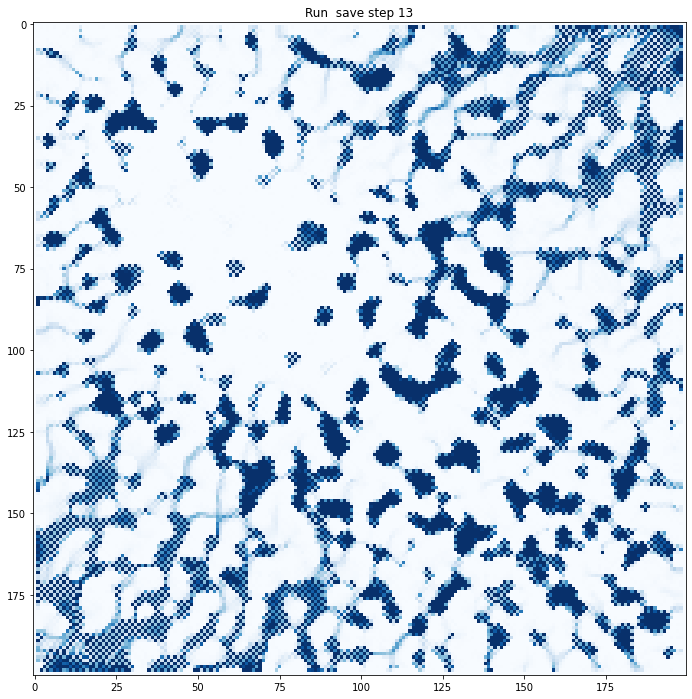

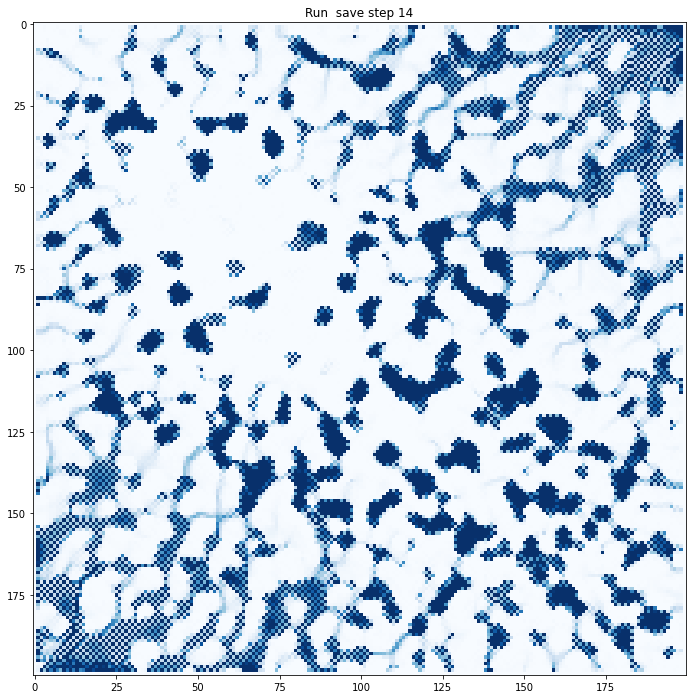

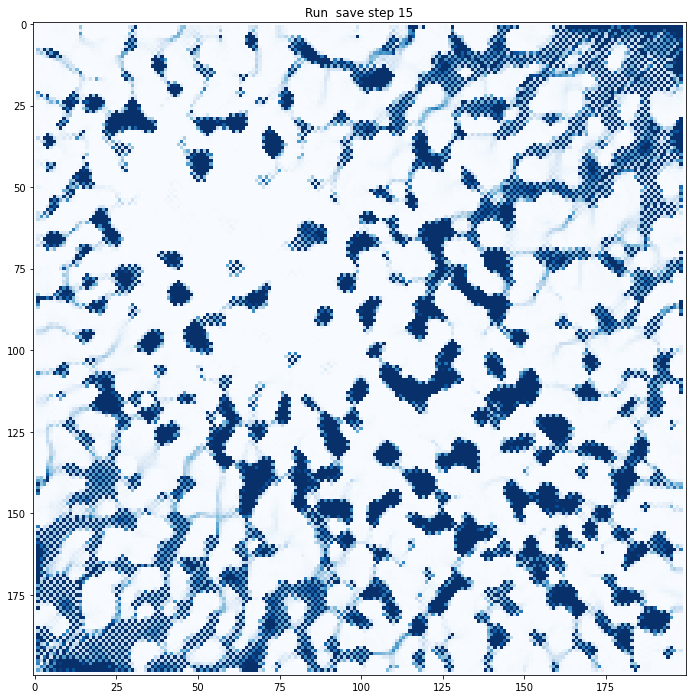

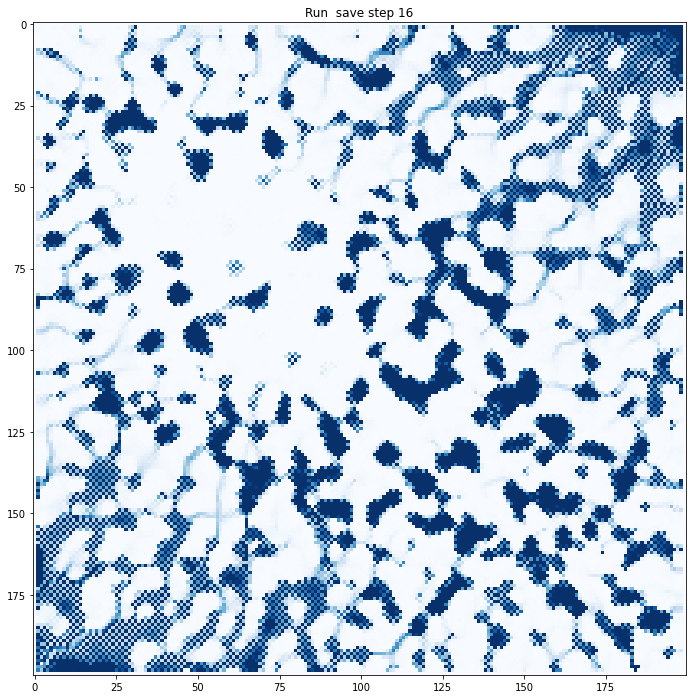

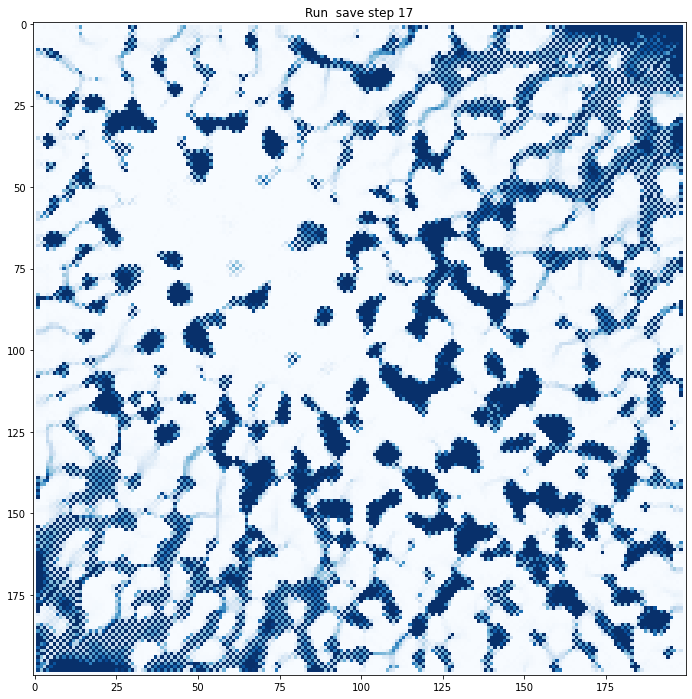

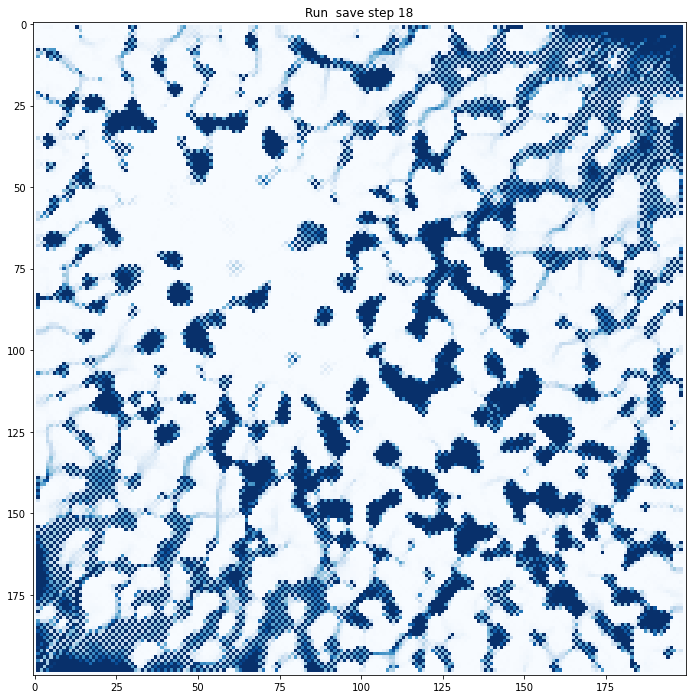

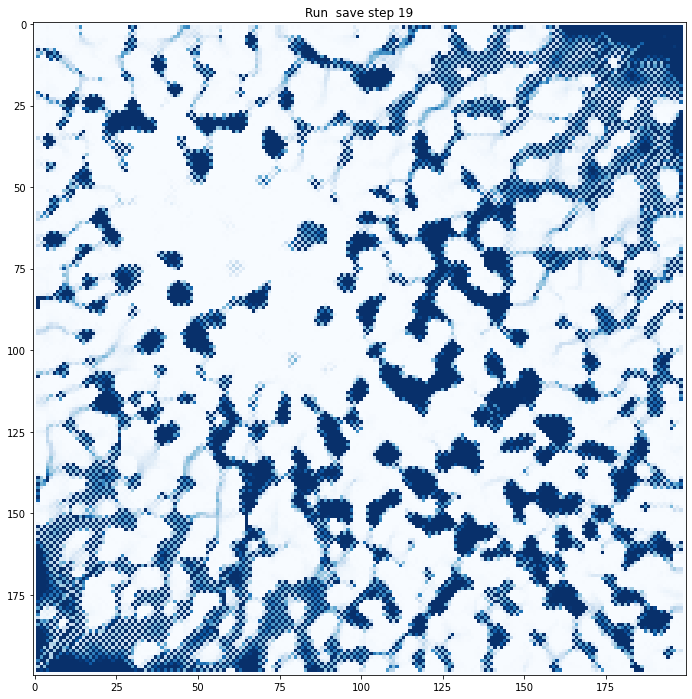

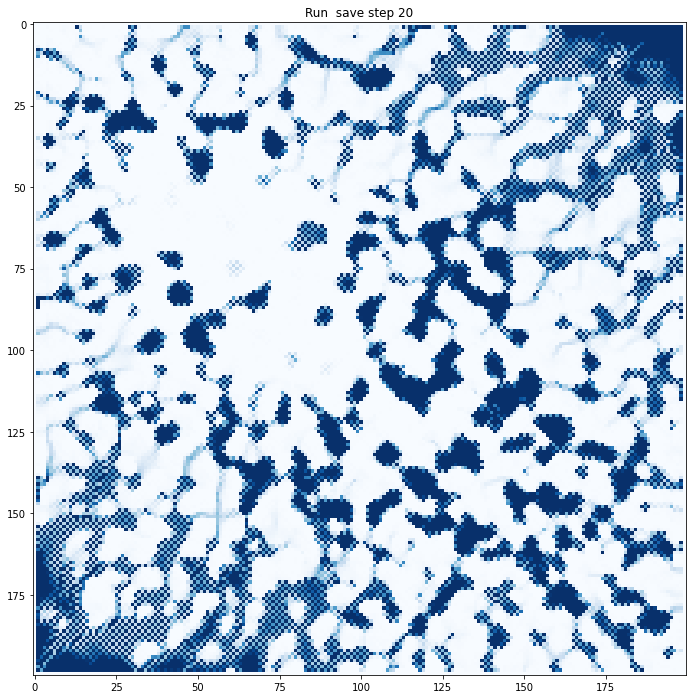

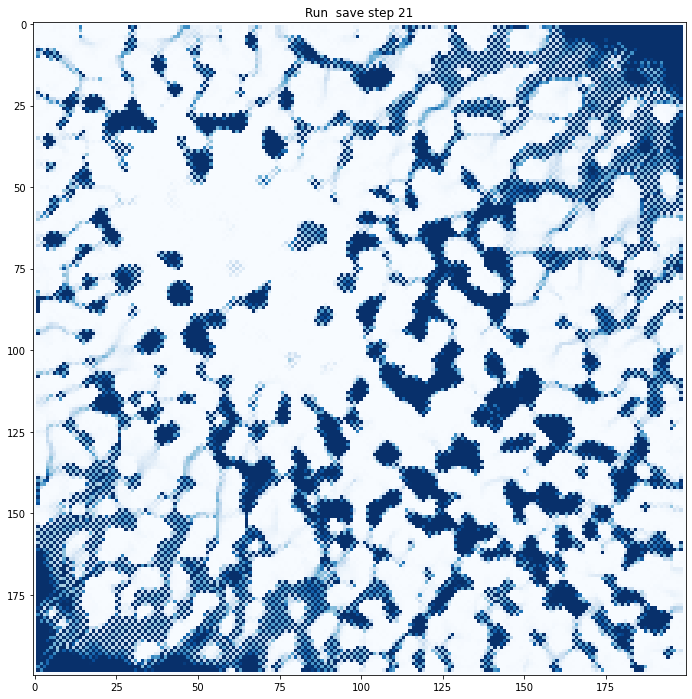

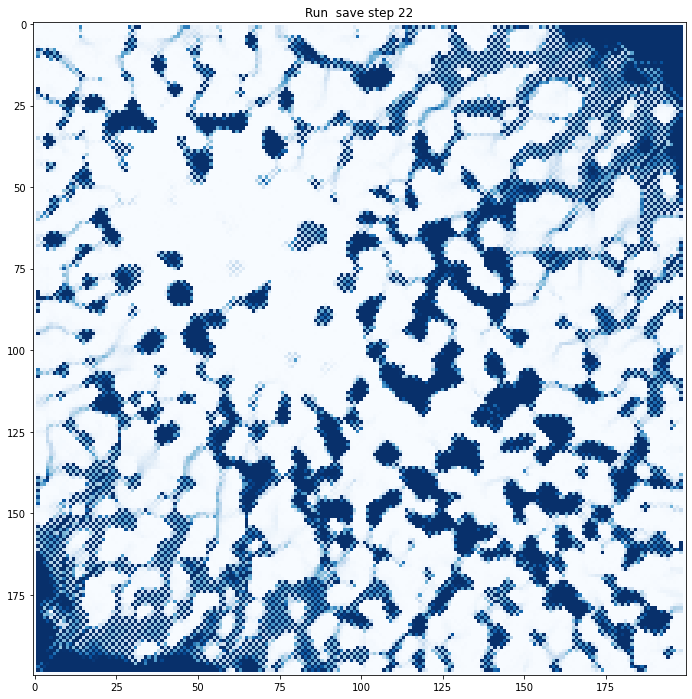

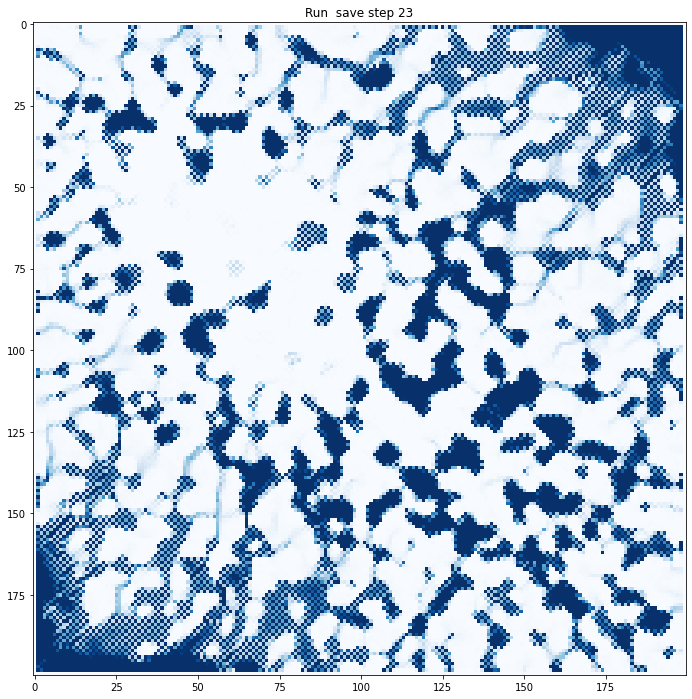

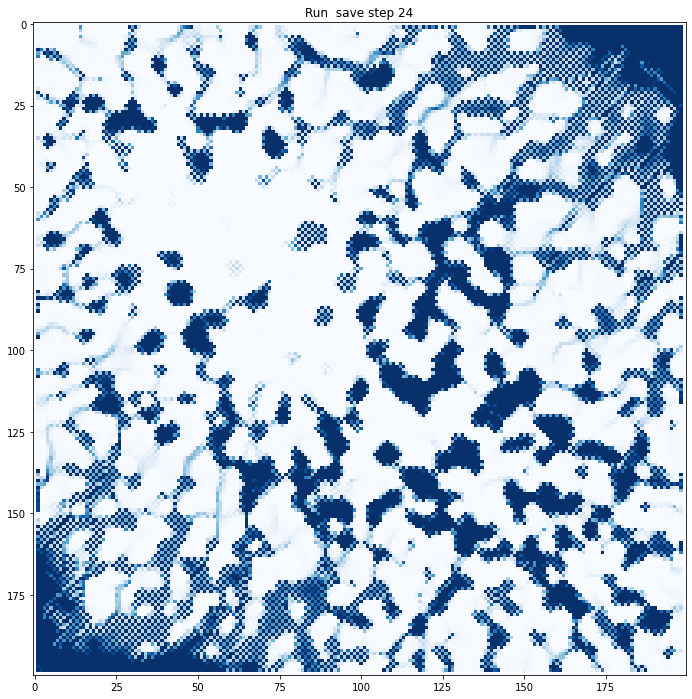

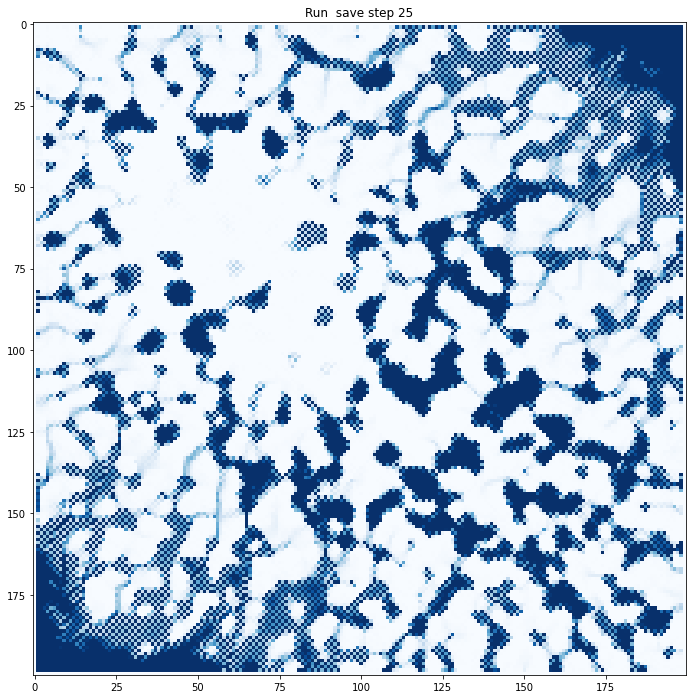

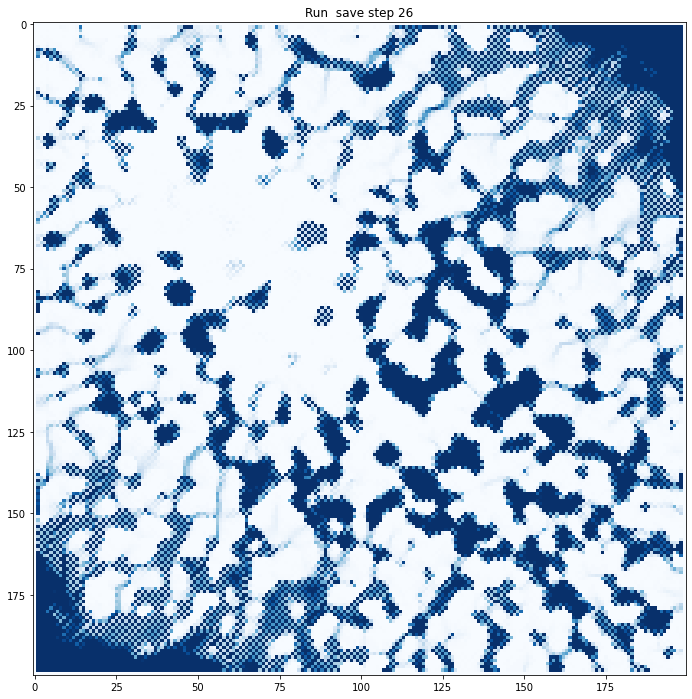

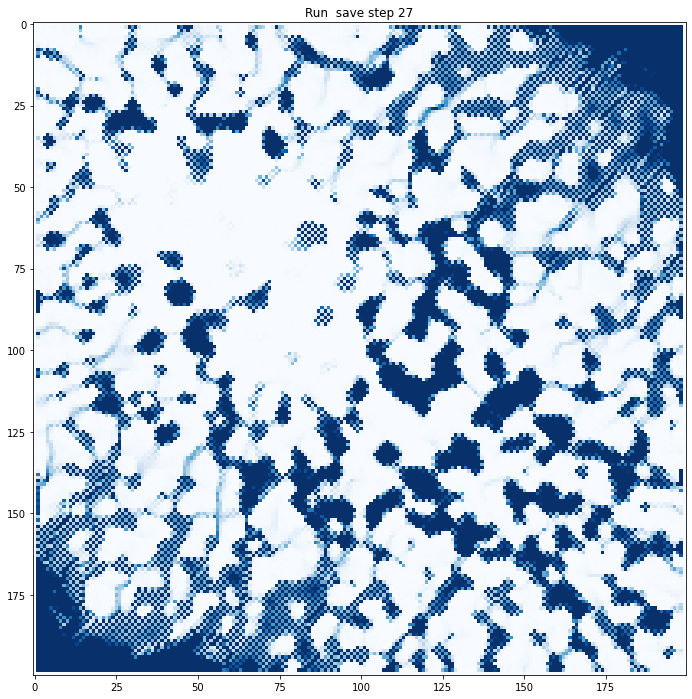

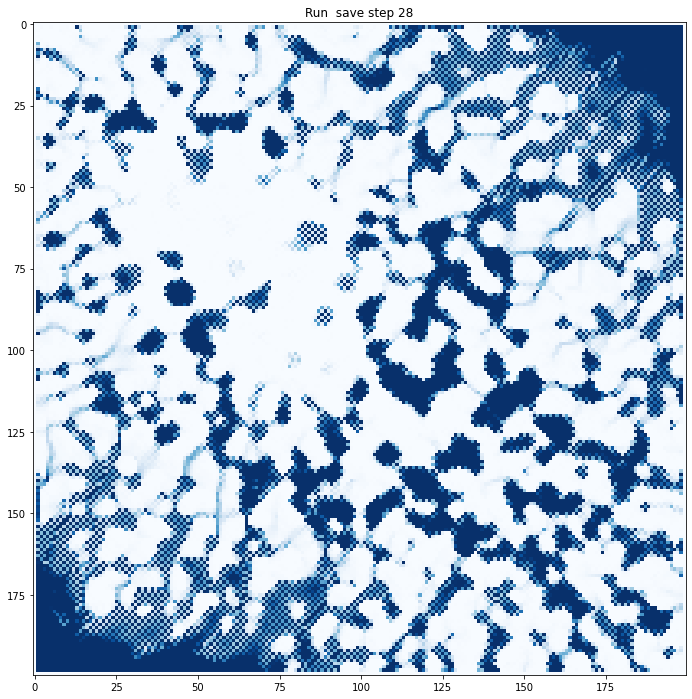

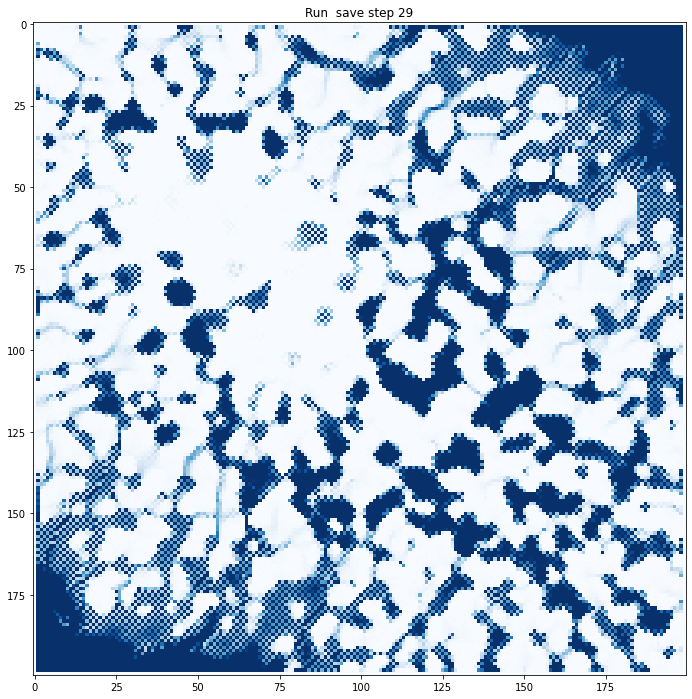

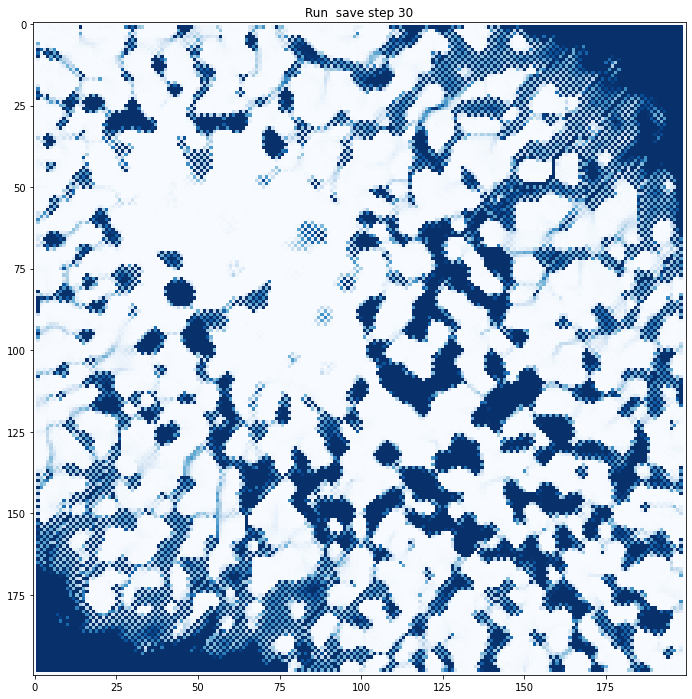

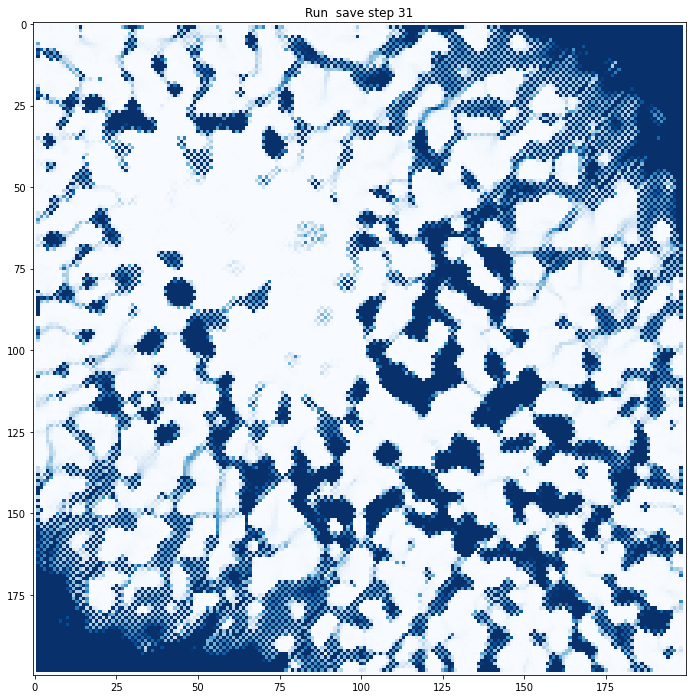

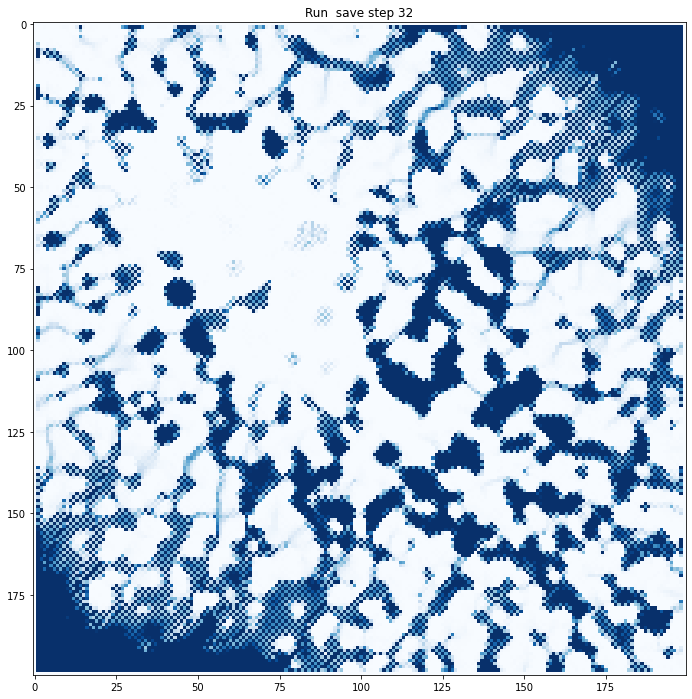

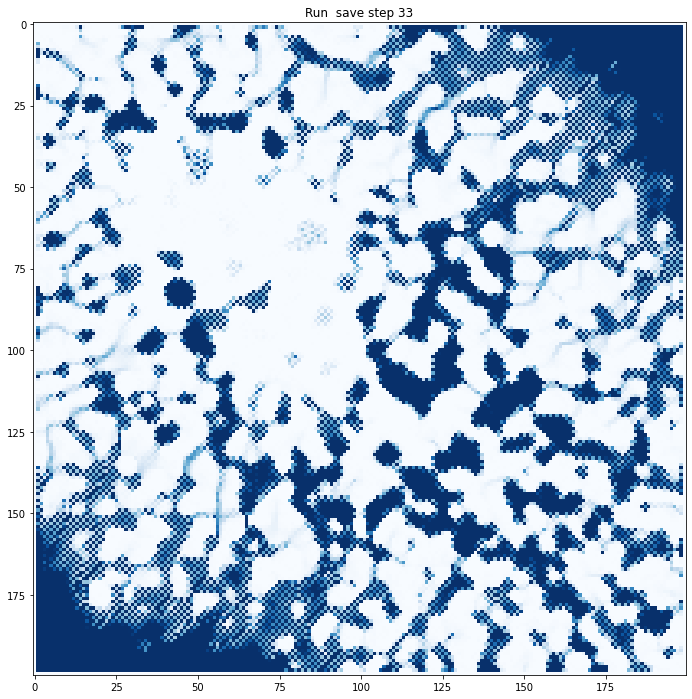

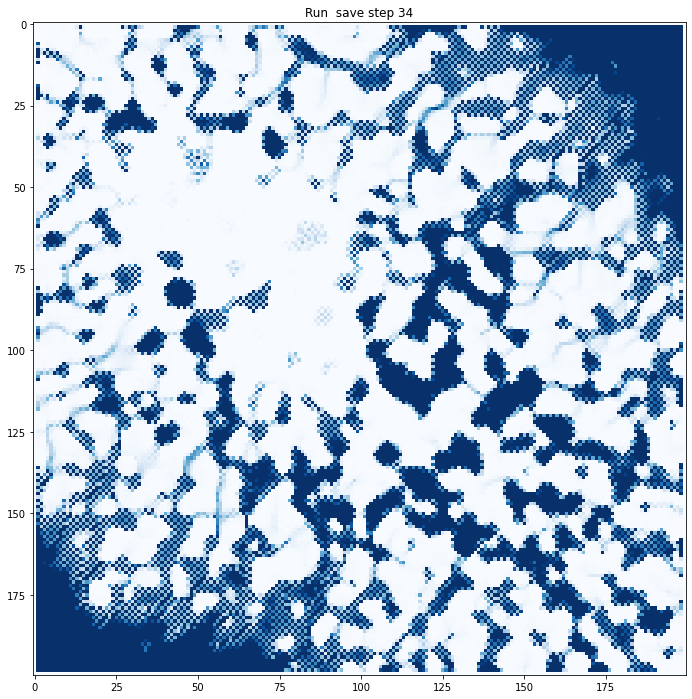

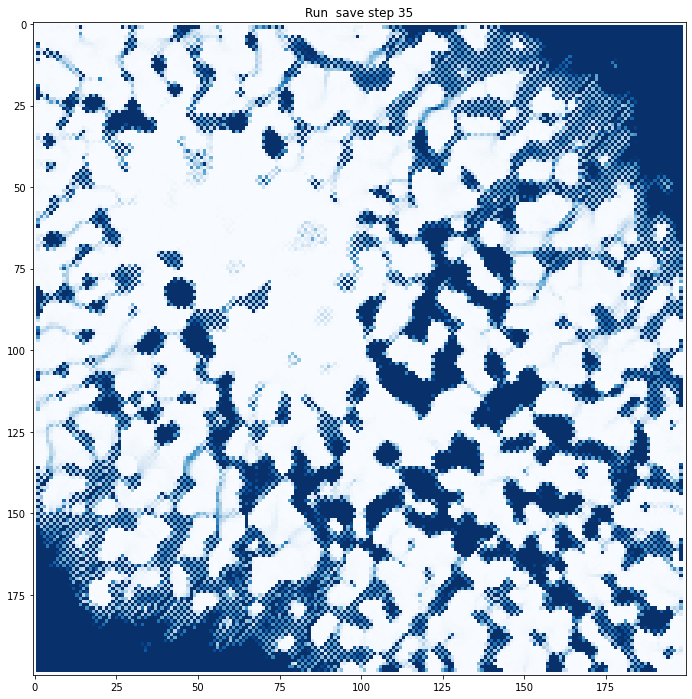

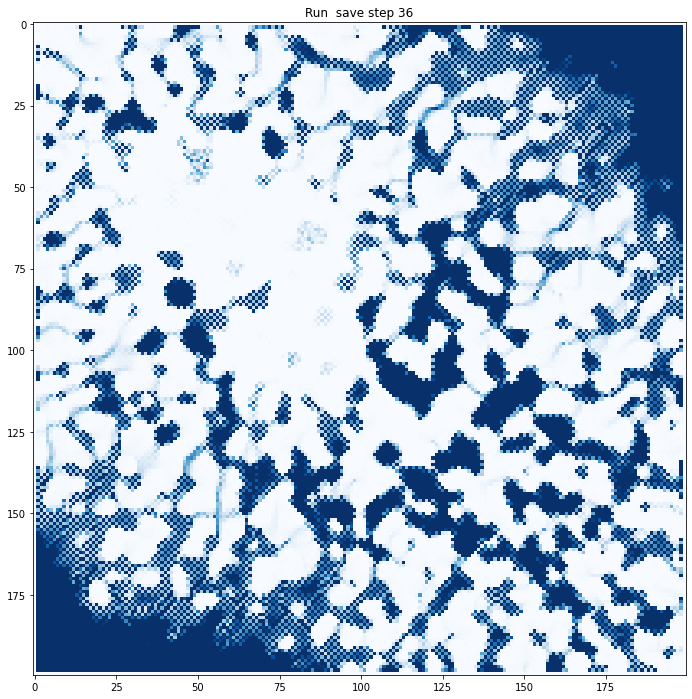

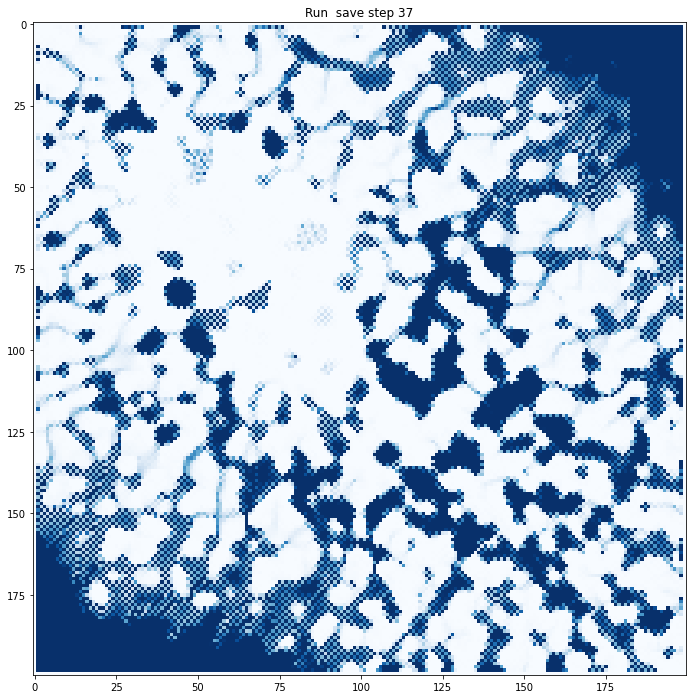

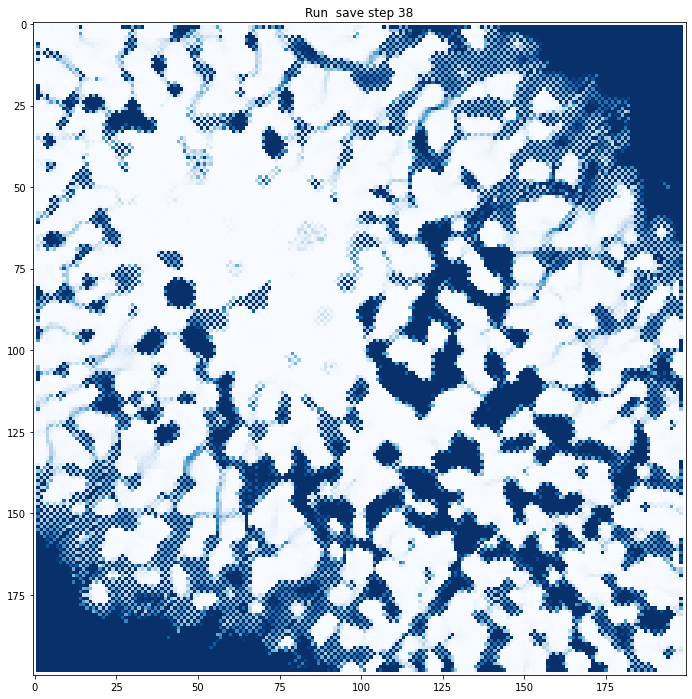

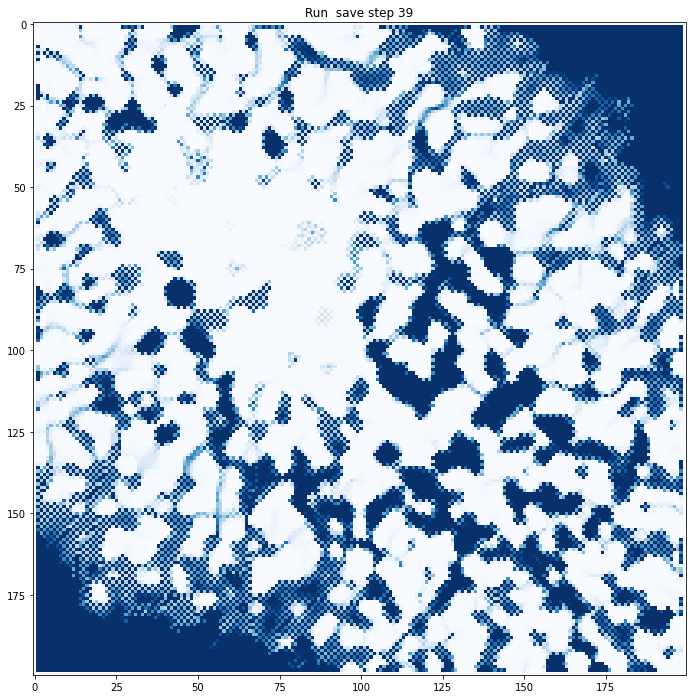

In [267]:
for i in np.arange(40):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
    tmp = all_gravel[i] + all_rock[i]
    ax.imshow(tmp, cmap=plt.cm.terrain, )

#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

#     alphas = all_waters[i] / 10
#     alphas[alphas > 1] = 1
#     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)
    ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=1)

In [ ]:
plt.hist(np.log10(tmp.flatten()))
None

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
title = "Run  save step " + str(i)
ax.set_title(title)    
# tmp1 = ((all_gravel[-1] + all_rock[-1]) + (all_gravel[-2] + all_rock[-2])) / 2. 
tmp = all_waters[-1]
ax.imshow(tmp, vmax=1000, cmap=plt.cm.Blues)

In [ ]:
for i in np.arange(40):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    title = "Run  save step " + str(i)
    ax.set_title(title)
    
#     tmp = ndimage.zoom(all_gravel[i] + all_rock[i], 4)
    tmp = all_gravel[i] - all_gravel[0]# + all_rock[i]
    ax.imshow(tmp, cmap=plt.cm.BrBG, vmin=-20, vmax=20)

#         ax.imshow(all_gravel[j][i], cmap=plt.cm.terrain, )
#     tmp = ndimage.zoom(, 4)

#     alphas = all_waters[i] / 20
#     alphas[alphas > 1] = 1
#     ax.imshow(all_waters[i], cmap=plt.cm.Blues, vmin=0, vmax=10, alpha=alphas)

In [14]:
water.sum()

NameError: name 'water' is not defined

In [ ]:
len(zland.flatten())